In [416]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import KFold
from KL.kl.utils import load_fx

# Set manual seed for reproducibility
torch.manual_seed(42)

# Load data
X, _, _, y, _ = load_fx(data_start=0, data_end=6000, shift=4, window_size=10, pair='EURUSD')

# Convert numpy arrays to PyTorch tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

# Train/Test split
train_data, test_data = X[:5500], X[5500:]
train_target, test_target = y[:5500], y[5500:]


In [417]:
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, latent_size):
        super(Encoder, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(p=0.3)
        self.fc_mu = nn.Linear(hidden_size, latent_size)
        self.fc_logvar = nn.Linear(hidden_size, latent_size)

    def forward(self, x):
        _, (h_n, _) = self.lstm(x)  # LSTM encoder
        h_n = h_n.view(x.size(0), -1)  # Proper reshaping to keep batch size
        h_n = self.dropout(h_n)
        mu = self.fc_mu(h_n)  # Mean
        logvar = self.fc_logvar(h_n)  # Log variance
        return mu, logvar

In [418]:
class Decoder(nn.Module):
    def __init__(self, latent_size, output_size):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(latent_size, output_size)

    def forward(self, z):
        return self.fc(z)

In [419]:
class VAE(nn.Module):
    def __init__(self, input_size, hidden_size, latent_size, output_size, num_classes):
        super(VAE, self).__init__()
        self.encoder = Encoder(input_size, hidden_size, latent_size)
        self.decoder = Decoder(latent_size, input_size)  # Transform X
        self.fc_pred = nn.Linear(latent_size, output_size)  # Prediction layer for y
        self.classifier = nn.Linear(latent_size, num_classes)  # Classification layer for y

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        class_pred = self.classifier(z)
        y_pred = self.fc_pred(z)
        X_transformed = self.decoder(z)
        return y_pred, X_transformed, class_pred, mu, logvar

    def reparameterize(self, mu, logvar):
        return mu

In [420]:
def loss_function(recon_x, x, y_true, class_pred, mu, logvar, beta=1.0):
    # Ensure y_true is 1D for CrossEntropyLoss
    y_true = y_true.squeeze(-1)

    # Reshape recon_x to match the shape of x
    recon_x = recon_x.view_as(x)  # Ensure they have the same shape

    # Reconstruction loss (e.g., for X_transformed)
    reconstruction_loss = nn.MSELoss()(recon_x, x)

    # Ensure class_pred shape is [batch_size, num_classes] and y_true is [batch_size]
    classification_loss = nn.CrossEntropyLoss()(class_pred, y_true.long())

    # KL Divergence (maximize)
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    # loss = reconstruction_loss / (1+ beta * kl_divergence) + classification_loss# - First I try it was not bad
    target_kl = 100.0  # Adjust this based on your desired latent space regularization
    gamma = 1.0  # Tune this to control how much weight you want to give to the KL term

    #loss = reconstruction_loss + classification_loss + gamma * (kl_divergence - target_kl).pow(2)
    # Combine losses
    #return reconstruction_loss + classification_loss / (1 + beta * kl_divergence) 
    loss = classification_loss / (1 + beta * kl_divergence) 
    return loss

In [421]:
# Early Stopping
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float('inf')
        self.counter = 0

    def step(self, validation_loss):
        if validation_loss < self.best_loss - self.min_delta:
            self.best_loss = validation_loss
            self.counter = 0
        else:
            self.counter += 1
        return self.counter >= self.patience

In [422]:
# Weight reset
def reset_weights(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.LSTM):
        m.reset_parameters()

In [423]:
# Cross-validation with early stopping
def cross_validate_with_early_stopping(data, target, model, criterion, optimizer, epochs=1000, k_folds=5, patience=10, beta=1.0, print_every=10):
    kfold = KFold(n_splits=k_folds, shuffle=True)

    for fold, (train_idx, test_idx) in enumerate(kfold.split(data)):
        print(f"Fold {fold + 1}/{k_folds}")

        train_data = data[train_idx].unsqueeze(1)  # Shape: [batch_size, sequence_length, input_size]
        train_target = target[train_idx]
        test_data = data[test_idx].unsqueeze(1)  # Shape: [batch_size, sequence_length, input_size]
        test_target = target[test_idx]

        train_dataset = TensorDataset(train_data, train_target)
        test_dataset = TensorDataset(test_data, test_target)

        train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

        model.apply(reset_weights)

        early_stopper = EarlyStopping(patience=patience)

        for epoch in range(epochs):
            model.train()
            for batch_data, batch_target in train_loader:
                optimizer.zero_grad()
                y_pred, X_transformed, class_pred, mu, logvar = model(batch_data)
                loss = criterion(X_transformed, batch_data, batch_target, class_pred, mu, logvar, beta=beta)
                nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                loss.backward()
                optimizer.step()

            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for batch_data, batch_target in test_loader:
                    y_pred, X_transformed, class_pred, mu, logvar = model(batch_data)
                    loss = criterion(X_transformed, batch_data, batch_target, class_pred, mu, logvar, beta=beta)
                    val_loss += loss.item()

            val_loss /= len(test_loader)
            if epoch % print_every == 0:
                print(f"Epoch {epoch + 1}/{epochs} | Validation Loss: {val_loss}")

            if early_stopper.step(val_loss):
                print(f"Early stopping at epoch {epoch + 1}")
                break

        print(f"Best validation loss for fold {fold + 1}: {early_stopper.best_loss}")

In [424]:
# Model initialization
factor = 1
input_size = 8
hidden_size = 64 * factor
latent_size = 32#3 increase from 3 to 32
output_size = 1

model = VAE(input_size=input_size, hidden_size=hidden_size, latent_size=latent_size, output_size=output_size, num_classes=2)
optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-5)

# Perform cross-validation
Beta = 0.005
cross_validate_with_early_stopping(data=train_data, target=train_target, model=model, criterion=loss_function, optimizer=optimizer, epochs=2000, beta=Beta, print_every=100)

Fold 1/5
Epoch 1/2000 | Validation Loss: 0.6556373768382602
Epoch 101/2000 | Validation Loss: 0.2598077091905806
Epoch 201/2000 | Validation Loss: 0.07563196246822675
Epoch 301/2000 | Validation Loss: 0.021124128562708695
Epoch 401/2000 | Validation Loss: 0.0038091581987424027
Epoch 501/2000 | Validation Loss: 0.0004979977804598295
Epoch 601/2000 | Validation Loss: 0.00016039160355932027
Epoch 701/2000 | Validation Loss: 9.482462418317381e-05
Epoch 801/2000 | Validation Loss: 7.651321296483123e-05
Early stopping at epoch 823
Best validation loss for fold 1: 7.500617114904647e-05
Fold 2/5
Epoch 1/2000 | Validation Loss: 0.6609531839688619
Epoch 101/2000 | Validation Loss: 0.2176666350828277
Epoch 201/2000 | Validation Loss: 0.06056416200266944
Epoch 301/2000 | Validation Loss: 0.014520081898404492
Epoch 401/2000 | Validation Loss: 0.0020327011524285707
Epoch 501/2000 | Validation Loss: 0.0002792445633935535
Epoch 601/2000 | Validation Loss: 0.00011694743241403355
Epoch 701/2000 | Valida

In [425]:
# Prediction function for test data
def predict_batch(model, test_data):
    test_dataset = TensorDataset(test_data)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    model.eval()
    all_predicted = []
    all_transformed_X = []
    with torch.no_grad():
        for batch_data in test_loader:
            batch_data = batch_data[0]
            y_pred, X_transformed, class_pred, mu, logvar = model(batch_data)
            all_transformed_X.append(X_transformed)
            all_predicted.append(y_pred)

    all_predicted = torch.cat(all_predicted, dim=0)
    all_transformed_X = torch.cat(all_transformed_X, dim=0)
    return all_predicted, all_transformed_X

In [426]:
# Final evaluation on the test samples
test_data = test_data.view(-1, 1, 8)
all_predicted, all_transformed_X = predict_batch(model, test_data)
print(f"All outputs shape: {all_predicted.shape}")
print(f"All transformed X shape: {all_transformed_X.shape}")

# Convert outputs to probabilities and compute accuracy
predicted = torch.sigmoid(all_predicted)
predicted_classes = (predicted > 0.5).float()

# Compute accuracy
accuracy = (predicted_classes == test_target).float().mean()
print(f"Accuracy: {accuracy.item() * 100:.2f}%")

All outputs shape: torch.Size([490, 1])
All transformed X shape: torch.Size([490, 8])
Accuracy: 53.06%


In [427]:
# Convert the transformed X to numpy for PCA
all_transformed_X_np = all_transformed_X.detach().numpy()
all_predicted_X_np = all_predicted.detach().numpy()
test_target_np = test_target.detach().numpy()

In [428]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Perform PCA to reduce dimensions to 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(all_transformed_X_np)

print(f"Reduced X shape: {X_pca.shape}") 

Reduced X shape: (490, 2)


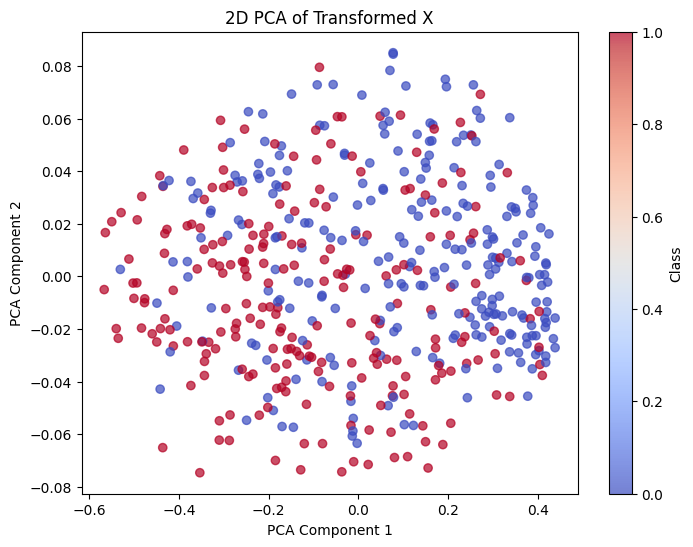

In [429]:
plt.figure(figsize=(8, 6))
# plt.scatter(X_pca[:, 0], X_pca[:, 1], c=all_predicted_y_np, cmap='coolwarm', alpha=0.7)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=test_target_np, cmap='coolwarm', alpha=0.7)
plt.colorbar(label='Class')
plt.title('2D PCA of Transformed X')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.savefig('2D_PCA_of_Transformed_X.png')
plt.show()

In [430]:
# Final evaluation on the train samples
# test_data = test_data.view(-1, 1, 8)
train_data = train_data.view(-1, 1, 8)
all_predicted, all_transformed_X_trn = predict_batch(model, train_data)
print(f"All outputs shape: {all_predicted.shape}")
print(f"All transformed X shape: {all_transformed_X_trn.shape}")

# Convert outputs to probabilities and compute accuracy
predicted = torch.sigmoid(all_predicted)
predicted_classes = (predicted > 0.5).float()

# Compute accuracy
accuracy = (predicted_classes == train_target).float().mean()
print(f"Accuracy: {accuracy.item() * 100:.2f}%")

All outputs shape: torch.Size([5500, 1])
All transformed X shape: torch.Size([5500, 8])
Accuracy: 48.38%


In [431]:
pca = PCA(n_components=2)
all_transformed_X_trn_np = all_transformed_X_trn.detach().numpy()
X_pca = pca.fit_transform(all_transformed_X_trn_np)

print(f"Reduced X shape: {X_pca.shape}") 
train_target_np = train_target.detach().numpy()

Reduced X shape: (5500, 2)


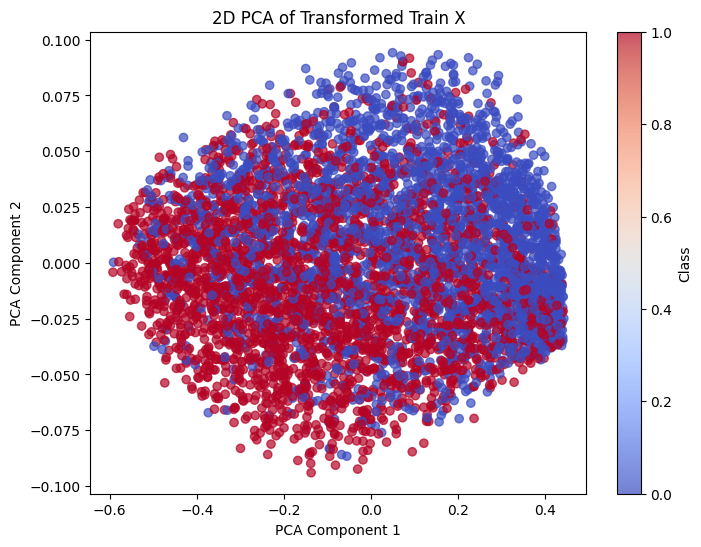

In [432]:
plt.figure(figsize=(8, 6))
# plt.scatter(X_pca[:, 0], X_pca[:, 1], c=all_predicted_y_np, cmap='coolwarm', alpha=0.7)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=train_target_np, cmap='coolwarm', alpha=0.7)
plt.colorbar(label='Class')
plt.title('2D PCA of Transformed Train X')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.savefig('2D_PCA_of_Transformed_X_Train.png')
plt.show()